In [1]:
import random
import math

# Pruebas Montecarlo

In [2]:
def f(x):
    return 1.0/math.sqrt(1-x*x)

In [3]:
iterations = 1000000
total = 0.0
for i in range(iterations):
    x = random.random()
    total += f(x) - 1.0
total = total / iterations

In [4]:
2.0 + total*2

3.1427151042375567

In [5]:
iterations = 1000000
total = 0.0
for i in range(iterations):
    x = random.random()
    total += f(x)
total = total / iterations

In [6]:
total*2

3.142572089377215

# Lectura de datos

In [7]:
import regex as re
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
def cargar_fichero(fichero="resultados.out"):
    filas = []
    with open("resultados.out", "r") as f:
        content = f.read()
        content = re.split(r'Ejecutando con (\d+) nodos y (\d+) procesadores', content)[1:]
        
        print(content)
        
        for n_procesadores, resultados in [(content[i],content[i+1]) for i in range(0,len(content),2)]:        
            pattern = r"Global approx of PI with (\d+) iterations:\n" \
              r"\s+-is (\d+\.\d+)\n" \
              r"\s+-has an error [+-]?(\d+\.\d+e[+-]?\d+)\n" \
              r"\s+-took (\d+\.\d+e[+-]?\d+) seconds\n" \
              r"\s+-quality [+-]?(\d+\.\d+e[+-]?\d+)"
            matches = re.finditer(pattern, resultados)
            match = next(matches)
            iterations, pi_approx, error, time_taken, quality = match.groups()

            filas.append({
                "procesadores": n_procesadores,
                "iteraciones": int(iterations),
                "pi_approx": float(pi_approx),
                "error": float(error),
                "tiempo": float(time_taken),
                "calidad": float(quality),
            })
    df = pd.DataFrame(filas)
    del filas
    
    return df

In [18]:
df = cargar_fichero("resultados.out")

[]


In [15]:
df

""


KeyError: 'procesadores'

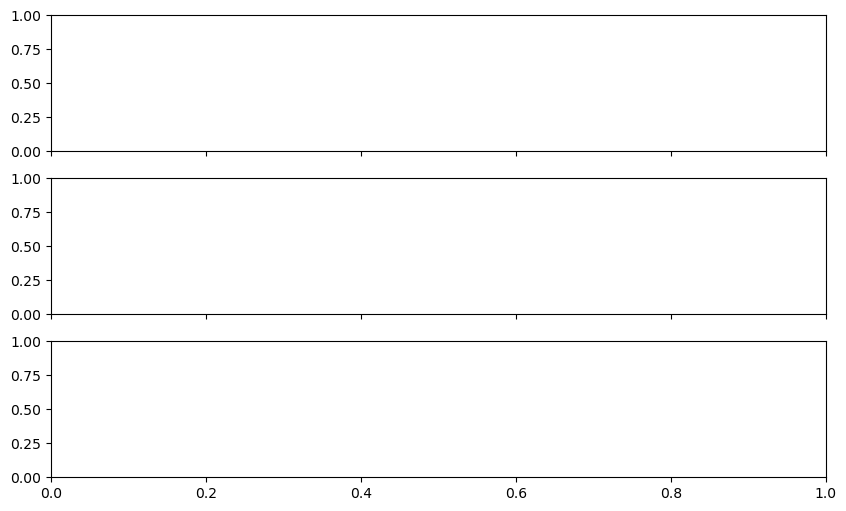

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 6), sharex=True)

# Subgráfica 1: Tiempo tomado en función del número de procesadores
ax1.plot(df['procesadores'], df['tiempo'], marker='o', linestyle='-')
ax1.grid()
ax1.set_ylabel('Tiempo (s)')
ax1.set_title('Tiempo y Calidad en función de Procesadores')

# Subgráfica 2: Calidad en función del número de procesadores
ax2.plot(df['procesadores'], df['calidad'], marker='o', linestyle='-')
ax2.grid()
ax2.set_ylabel('Calidad')

# Subgráfica 3: Calidad en función del número de procesadores
ax3.plot(df['procesadores'], df['error'], marker='o', linestyle='-')
ax3.grid()
ax3.set_xlabel('# Procesadores')
ax3.set_ylabel('Error')

# Ajusta el espacio entre las subgráficas para evitar superposiciones de etiquetas
plt.tight_layout()
plt.savefig('grafica.png', dpi=300)

# Muestra el gráfico
plt.show()